# RNN - Air Pollution

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
df = pd.read_csv('data/air_pollution.txt')

In [28]:
df.set_index('No', inplace=True)
df = df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Iws', 'Is']]

<AxesSubplot:xlabel='No'>

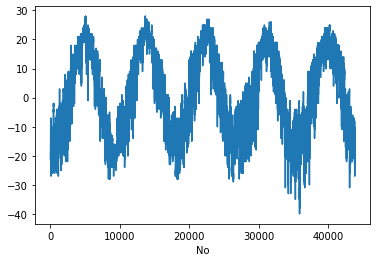

In [29]:
df.DEWP.plot()

Normalize variables

In [30]:
df['pm2.5'] = df['pm2.5']/1000
df['PRES'] = df['PRES']/1000

In [31]:
def subsample_sequence(df, length):
    value = df.sample(1).index[0]
    idx_position = df.index.get_loc(value)
    if len(df) - length < idx_position:
        return subsample_sequence(df, length)    
    return df.loc[value:value+length-1]

df_subsample = subsample_sequence(df, length=10)

In [37]:
def split_subsample_sequence(df, length):
    df_subsample = subsample_sequence(df, length)
    X_subsample = df_subsample[0:-1]
    y_subsample = df_subsample[-1:]['pm2.5'].iloc[0]
    if y_subsample == np.nan:
        return split_subsample_sequence(df, length)
    if X_subsample.isna()['pm2.5'].sum() == 0:
        pass
    elif X_subsample.isna()['pm2.5'].sum() == length:
        X_subsample.fillna(df['pm2.5'].mean(), inplace=True)
    else:
        X_subsample.fillna(X_subsample['pm2.5'].mean(), inplace=True)
    return X_subsample.to_numpy(), y_subsample

(X_sample, y_sample) = split_subsample_sequence(df, 10)

In [38]:
def get_X_y(df, number_of_sequences, length):
    for i in range(number_of_sequences):
        df_subsample = split_subsample_sequence(df, length)
        if i == 0:
            X =np.vstack(([df_subsample[0]],))
            y =np.vstack(([df_subsample[1]],))
        else:
            X =np.vstack(([df_subsample[0]],X))
            y =np.vstack(([df_subsample[1]],y))
    return X, y[:,0]

In [39]:
X, y = get_X_y(df, 100, 21)

In [40]:
X.shape

(100, 20, 7)

In [41]:
X, y = get_X_y(df, 2000, 21)

In [43]:
df_train = df.iloc[0:round(len(df) * 0.8)]
df_test = df.iloc[round(len(df) * 0.8):]
print(df_test.shape)
df_train.shape

(8765, 7)


(35059, 7)

In [44]:
X_train, y_train = get_X_y(df_train, 2000, 100)
X_test, y_test = get_X_y(df_test, 400, 100)

In [284]:
def init_model():
    metric = metrics.MAPE

    model = Sequential()

    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    model.add(normalizer)
    model.add(LSTM(units=10, activation='tanh'))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    model.compile(loss='mse',
                  metrics=metric,
                  optimizer='rmsprop') # Use `rmsprop`
    return model

In [285]:
model = init_model()

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
              epochs=1000,  # Use early stop in practice
              batch_size=16, 
              verbose=1,
              callbacks=[es],
              validation_split=0.2)

model.evaluate(X_test, y_test)

Epoch 1/1000
100/100 [==============================] - 2s 14ms/step - loss: 0.0064 - mean_absolute_percentage_error: 134.9958 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 83.9409
Epoch 2/1000
100/100 [==============================] - 1s 11ms/step - loss: 0.0020 - mean_absolute_percentage_error: 72.4182 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 64.2567
Epoch 3/1000
100/100 [==============================] - 1s 11ms/step - loss: 0.0015 - mean_absolute_percentage_error: 56.5905 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 55.3846
Epoch 4/1000
100/100 [==============================] - 1s 11ms/step - loss: 0.0013 - mean_absolute_percentage_error: 50.8397 - val_loss: 0.0011 - val_mean_absolute_percentage_error: 51.3823
Epoch 5/1000
100/100 [==============================] - 1s 12ms/step - loss: 0.0011 - mean_absolute_percentage_error: 48.1010 - val_loss: 9.4290e-04 - val_mean_absolute_percentage_error: 43.5520
Epoch 6/1000
100/100 [==================

[0.0007603096892125905, 34.6536865234375]

In [282]:
y_pred = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAPE on the test set : {res[1]:.0f} %')

Benchmark MAPE on the test set : 240 %
Benchmark MAPE on the test set : 19 %
MAPE on the test set : 38 %


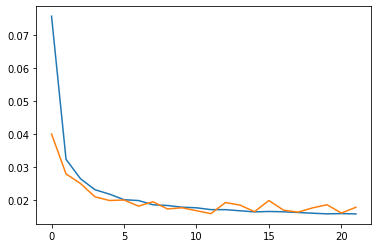

In [276]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

## Stack RNN layers

In [287]:
def init_model_2():
    metric = metrics.MAPE

    model = Sequential()

    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    model.add(normalizer)
    model.add(layers.SimpleRNN(units=10, activation='tanh'))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    model.compile(loss='mse',
                  metrics=metric,
                  optimizer='rmsprop') # Use `rmsprop`
    return model

In [288]:
model = init_model_2()

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
              epochs=1000,  # Use early stop in practice
              batch_size=16, 
              verbose=1,
              callbacks=[es],
              validation_split=0.2)

model.evaluate(X_test, y_test)

Epoch 1/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.0311 - mean_absolute_percentage_error: 355.3450 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 180.9863
Epoch 2/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0057 - mean_absolute_percentage_error: 157.6231 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 99.5424
Epoch 3/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.0029 - mean_absolute_percentage_error: 107.4928 - val_loss: 0.0021 - val_mean_absolute_percentage_error: 70.8605
Epoch 4/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0020 - mean_absolute_percentage_error: 88.5217 - val_loss: 0.0015 - val_mean_absolute_percentage_error: 63.6223
Epoch 5/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.0015 - mean_absolute_percentage_error: 73.2050 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 67.5739
Epoch 6/1000
100/100 [========================

[0.0006613968289457262, 30.761852264404297]

## Subsample in sequence of different lenghts

In [49]:
df_train = df.iloc[0:round(len(df) * 0.8)]
df_test = df.iloc[round(len(df) * 0.8):]

In [50]:
def subsample_sequence(df, length):
    value = df.sample(1).index[0]
    idx_position = df.index.get_loc(value)
    if len(df) - length < idx_position:
        return subsample_sequence(df, length)    
    return df.loc[value:value+length-1]

In [53]:
def get_X_y(df, sequence_lengths):
    for idx, length in enumerate(sequence_lengths):
        df_subsample = subsample_sequence(df, length)
        X_subsample = df_subsample.drop(columns='pm2.5')
        y_subsample = df_subsample['pm2.5']
        if y_subsample.isna().sum() == 0:
            pass
        elif y_subsample.isna().sum() == length:
            y_subsample.fillna(df['pm2.5'].mean(), inplace=True)
        else:
            y_subsample.fillna(y_subsample.mean(), inplace=True)
        if idx == 0:
            X =[np.array(X_subsample.to_numpy().tolist())]
            y =[np.array(y_subsample.to_numpy().tolist())]
        else:
            X.append(np.array(X_subsample.to_numpy().tolist()))
            y.append(np.array(y_subsample.to_numpy().tolist()))
            
    return np.array(X), np.array(y)

sequence_lengths_train = np.random.randint(15, 30, 1000)
X_train, y_train = get_X_y(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(20, 30, 200)
X_test, y_test = get_X_y(df_test, sequence_lengths_test)

<ipython-input-53-d8618f716e00>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), np.array(y)


In [56]:
X_test_pad = pad_sequences(X_test, dtype='float32', padding='post', value=-1000, maxlen=max(sequence_lengths_train))
y_test_pad = pad_sequences(y_test, dtype='float32', padding='post', value=-1000, maxlen=max(sequence_lengths_train))

X_train_pad = pad_sequences(X_train, dtype='float32', padding='post', value=-1000, maxlen=max(sequence_lengths_train))
y_train_pad = pad_sequences(y_train, dtype='float32', padding='post', value=-1000, maxlen=max(sequence_lengths_train))

In [57]:
y_train_pad =np.expand_dims(y_train_pad, axis=2)
y_test_pad = np.expand_dims(y_test_pad, axis=2)

In [59]:
def init_model():
    ### YOUR CODE HERE
    model = Sequential()

    model.add(layers.Masking(mask_value=-1000, input_shape=(29,6)))
    model.add(LSTM(units=10, activation='tanh', return_sequences=True))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    model.compile(loss='mse',
                  metrics=['mae'],
                  optimizer='rmsprop') # Use `rmsprop`
    return model

In [60]:
model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_pad,
            validation_split=0.2,
            epochs=1000, 
            batch_size=64,
            callbacks=[es], verbose=1)

Epoch 1/1000
13/13 [==============================] - 4s 78ms/step - loss: 0.2072 - mae: 0.3618 - val_loss: 0.1113 - val_mae: 0.2603
Epoch 2/1000
13/13 [==============================] - 0s 13ms/step - loss: 0.0822 - mae: 0.2231 - val_loss: 0.0507 - val_mae: 0.1785
Epoch 3/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0382 - mae: 0.1542 - val_loss: 0.0238 - val_mae: 0.1241
Epoch 4/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0179 - mae: 0.1080 - val_loss: 0.0119 - val_mae: 0.0907
Epoch 5/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0094 - mae: 0.0808 - val_loss: 0.0079 - val_mae: 0.0728
Epoch 6/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0067 - mae: 0.0681 - val_loss: 0.0069 - val_mae: 0.0677
Epoch 7/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0059 - mae: 0.0641 - val_loss: 0.0065 - val_mae: 0.0655
Epoch 8/1000
13/13 [==============================] - 0s 9ms/step - los

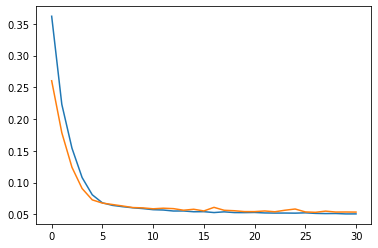

In [61]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

In [62]:
res = model.evaluate(X_test_pad, y_test_pad, verbose=0)
res

[0.006042855326086283, 0.0603807158768177]

In [63]:
def init_model_2():
    ### YOUR CODE HERE
    model = Sequential()

    model.add(layers.Masking(mask_value=-1000, input_shape=(29,6)))
    model.add(LSTM(units=10, activation='tanh', return_sequences=True))
    model.add(layers.Dense(40, activation="relu"))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    model.compile(loss='mse',
                  metrics=['mae'],
                  optimizer='rmsprop') # Use `rmsprop`
    return model

In [64]:
model = init_model_2()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_pad,
            validation_split=0.2,
            epochs=1000, 
            batch_size=64,
            callbacks=[es], verbose=1)

Epoch 1/1000
13/13 [==============================] - 4s 85ms/step - loss: 0.0133 - mae: 0.0977 - val_loss: 0.0064 - val_mae: 0.0652
Epoch 2/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0609 - val_loss: 0.0053 - val_mae: 0.0578
Epoch 3/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0047 - mae: 0.0564 - val_loss: 0.0048 - val_mae: 0.0584
Epoch 4/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0044 - mae: 0.0555 - val_loss: 0.0052 - val_mae: 0.0548
Epoch 5/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0042 - mae: 0.0537 - val_loss: 0.0048 - val_mae: 0.0532
Epoch 6/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0041 - mae: 0.0526 - val_loss: 0.0044 - val_mae: 0.0523
Epoch 7/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0041 - mae: 0.0528 - val_loss: 0.0044 - val_mae: 0.0510
Epoch 8/1000
13/13 [==============================] - 0s 11ms/step - 

13/13 [==============================] - 0s 12ms/step - loss: 0.0032 - mae: 0.0458 - val_loss: 0.0042 - val_mae: 0.0497
Epoch 63/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0032 - mae: 0.0463 - val_loss: 0.0044 - val_mae: 0.0513
Epoch 64/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0032 - mae: 0.0455 - val_loss: 0.0036 - val_mae: 0.0497
Epoch 65/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0032 - mae: 0.0458 - val_loss: 0.0039 - val_mae: 0.0485
Epoch 66/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0032 - mae: 0.0458 - val_loss: 0.0039 - val_mae: 0.0493
Epoch 67/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0032 - mae: 0.0457 - val_loss: 0.0038 - val_mae: 0.0475
Epoch 68/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0032 - mae: 0.0455 - val_loss: 0.0037 - val_mae: 0.0520
Epoch 69/1000
13/13 [==============================] - 0s 11ms/step - loss: 

In [65]:
model.evaluate(X_test_pad, y_test_pad, verbose=0)

[0.005420436151325703, 0.056760404258966446]